In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from scipy import stats

In [3]:
raw_data = pd.read_csv('data.csv', index_col=0, header=0, sep=',')

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат.  Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn.  Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции

Составим таблицу вида:

|        X       | STATE | STATE | ... | STATE |
|:--------------:|:-----:|:-----:|-----|-------|
|  CHURN == TRUE |   x   |   x2  | ... | xn    |
| CHURN == FALSE |   y   |   y2  | ... | yn    |

In [41]:
#stats.chi2_contingency(raw_data[raw_data["treatment"] == 1].churn)
data_treatment_1 = raw_data[raw_data["treatment"] == 1]

#   Эта штука была для ручной проверки
#data_treatment_1.groupby('state').agg(lambda x: list(x))

In [46]:
state_conjugate = pd.DataFrame(index=["CHURN_TRUE", "CHURN_FALSE"])

for state in data_treatment_1['state'].unique():
    buffer = data_treatment_1[data_treatment_1['state'] == state]
    buffer["churn"] = buffer["churn"].apply(lambda x: 1 if (str(x) == 'True.' or str(x) == '1') else 0)
    true_sum = sum(buffer["churn"])
    state_conjugate.loc["CHURN_TRUE", state] = true_sum
    state_conjugate.loc["CHURN_FALSE", state] = buffer.shape[0] - true_sum

state_conjugate = state_conjugate.astype(int)
#   Матрица соряженности есть, теперь засунем ее в провеку на независимость chi_2
#   Неправильно print("STAT = {0[0]:.4f}, P_VALUE={0[1]:.4f}".format(stats.chi2_contingency(state_conjugate.values, correction=False)))

STAT = 44.0527, P_VALUE=0.7098


<ipython-input-46-7d14f7a8afbc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buffer["churn"] = buffer["churn"].apply(lambda x: 1 if (str(x) == 'True.' or str(x) == '1') else 0)


In [139]:
chi2table = pd.DataFrame(columns=['P_VALUE', 'STAT'])
columns = state_conjugate.columns
for i,state in enumerate(columns):
    for state_2 in columns[i+1:]:
        stat,p_value = stats.chi2_contingency(state_conjugate[[state, state_2]].values, correction=False)[0:2]
        chi2table.loc[f"{state} {state_2}", 'STAT'] = stat
        chi2table.loc[f"{state} {state_2}", 'P_VALUE'] = p_value

chi2table

,P_VALUE,STAT
KS OH,0.075524,3.158685
KS LA,0.024052,5.090909
KS IA,0.28219,1.156511
KS VT,0.616769,0.250435
KS CO,0.679125,0.171113
...,...,...
IL HI,0.952933,0.003484
IL SC,0.267505,1.229497
ND HI,0.652998,0.202142
ND SC,0.322191,0.980031


In [88]:
np.unique(chi2table["P_VALUE"] < .05, return_counts=True)

(array([False,  True]), array([1241,   34]))

,P_VALUE,STAT
KS LA,0.024052,5.090909
KS AK,0.044934,4.021115
KS NM,0.037998,4.305103
OH CA,0.047788,3.917411
LA CO,0.047101,3.941761
LA MA,0.020937,5.332031
LA AR,0.018074,5.588942
LA MI,0.047101,3.941761
LA TX,0.019782,5.431034
LA ME,0.021755,5.265306


In [127]:
_buf_ = np.unique(state_conjugate.apply(lambda x: x < 5).values, return_counts=True)[1]
_buf_[1] / sum(_buf_) * 100
#   А должно быть меньше 20, иначе критерий хи-квадрат для сопряженных таблиц работает некорректно

33.33333333333333

In [118]:
state_conjugate

,KS,OH,LA,IA,VT,CO,WY,MO,GA,AK,...,WI,CA,NC,MD,TN,AL,IL,ND,HI,SC
CHURN_TRUE,7,2,0,2,5,5,2,4,2,1,...,2,5,3,5,1,5,1,3,1,5
CHURN_FALSE,18,22,15,13,18,17,20,17,19,19,...,22,10,16,19,11,25,11,21,12,16


In [157]:
chi2table = pd.DataFrame(columns=['P_VALUE', 'STAT'])
columns = state_conjugate.columns
for i,state in enumerate(columns):
    for state_2 in columns[i+1:]:
        stat,p_value = stats.chi2_contingency(state_conjugate[[state, state_2]].values, correction=True)[0:2]
        chi2table.loc[f"{state} {state_2}", 'STAT'] = stat
        chi2table.loc[f"{state} {state_2}", 'P_VALUE'] = p_value

chi2table

,P_VALUE,STAT
KS OH,0.159054,1.983196
KS LA,0.06777,3.336219
KS IA,0.493752,0.468339
KS VT,0.867518,0.027826
KS CO,0.937468,0.006155
...,...,...
IL HI,0.49728,0.460737
IL SC,0.522363,0.409226
ND HI,0.91645,0.011005
ND SC,0.549046,0.359028


In [132]:
np.unique(chi2table["P_VALUE"] < .05, return_counts=True)

(array([False]), array([1275]))

In [137]:
from tqdm.notebook import tqdm
#   Критерий Фишера, * даже страшно представить сколько он будет считаться
chi2table_fisher = pd.DataFrame(columns=['P_VALUE', 'STAT'])
columns = state_conjugate.columns
for i,state in tqdm(enumerate(columns), desc="External cycle", total=len(columns)):
    for state_2 in (columns[i+1:]):
        stat,p_value = stats.fisher_exact(state_conjugate[[state, state_2]].values)[0:2]
        chi2table_fisher.loc[f"{state} {state_2}", 'STAT'] = stat
        chi2table_fisher.loc[f"{state} {state_2}", 'P_VALUE'] = p_value

chi2table_fisher

External cycle:   0%|          | 0/51 [00:00<?, ?it/s]

,P_VALUE,STAT
KS OH,0.138333,4.277778
KS LA,0.03284,inf
KS IA,0.440083,2.527778
KS VT,0.743389,1.4
KS CO,0.747108,1.322222
...,...,...
IL HI,1.0,1.090909
IL SC,0.379171,0.290909
ND HI,1.0,1.714286
ND SC,0.442704,0.457143


In [138]:
np.unique(chi2table_fisher["P_VALUE"] < .05, return_counts=True)

(array([False,  True]), array([1265,   10]))

In [159]:
stats.ttest_ind(chi2table_fisher["P_VALUE"].values, chi2table["P_VALUE"].values, alternative="less")

Ttest_indResult(statistic=-1.3969857558554826, pvalue=0.08126975150497395)

In [143]:
stats.pearsonr(raw_data["day_calls"].values, raw_data["mes_estim"].values)
#   Гипотеза об отсутствии монотонной взаимосвязи на уровне значимости .05 отвергается
#   А вообще считать корреляцию Пирсона некорректно, так как данные не непрерывны * Я тупой, данные как раз непрерывны, ведь единица измерения признака - минуты, так что все в порядке

(-0.05179435058757264, 0.0027798836869738384)

In [144]:
stats.spearmanr(raw_data["day_calls"].values, raw_data["mes_estim"].values)

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

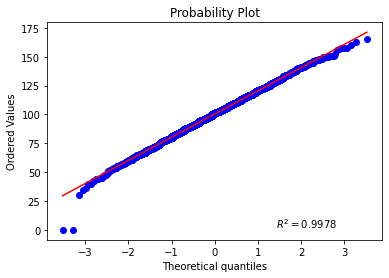

((array([-3.5297919 , -3.28786833, -3.15418238, ...,  3.15418238,
          3.28786833,  3.5297919 ]),
  array([0.05, 0.05, 0.05, ..., 0.89, 0.91, 0.96])),
 (0.13861708020693372, 0.4842364236423642, 0.9996050483985331))

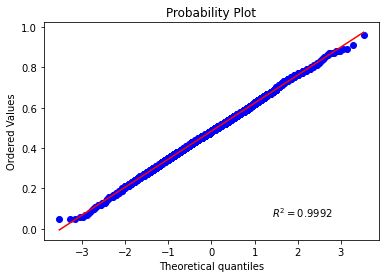

In [149]:
stats.probplot(raw_data["day_calls"].values, plot=plt, rvalue=True)
plt.show()
stats.probplot(raw_data["mes_estim"].values, plot=plt, rvalue=True)

In [156]:
chi_stat, p_stat = stats.chi2_contingency(state_conjugate.values)[:2]
print('P_VALUE:', p_stat)
V_Crammer = np.sqrt((chi_stat / np.sum(state_conjugate.values)) / (min(state_conjugate.shape) - 1))
V_Crammer

P_VALUE: 0.7097590042778473


0.2003932150203332

In [164]:
tr0 = raw_data[raw_data["treatment"] == 0]['churn'].apply(lambda x: 1 if (str(x) == 'False.' or str(x) == '1') else 0).values
tr1 = raw_data[raw_data["treatment"] == 1]['churn'].apply(lambda x: 1 if (str(x) == 'False.' or str(x) == '1') else 0).values
tr2 = raw_data[raw_data["treatment"] == 2]['churn'].apply(lambda x: 1 if (str(x) == 'False.' or str(x) == '1') else 0).values

In [165]:
print('0-1', stats.ttest_ind(tr0, tr1))
print('0-2', stats.ttest_ind(tr0, tr2))
print('1-2', stats.ttest_ind(tr1, tr2))

0-1 Ttest_indResult(statistic=1.2045205230813048, pvalue=0.2285163910842914)
0-2 Ttest_indResult(statistic=-1.4172019054376452, pvalue=0.15656334748097245)
1-2 Ttest_indResult(statistic=-2.601870748565941, pvalue=0.009333926332475618)
